[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/constantinpape/torch-em/blob/main/experiments/3D-UNet-Training.ipynb)

# 3D UNet Training

This notebook implements training of a 3D UNet with `torch_em`. It implements training for affinity, boundary and foreground prediction. The training code is also customizable to enable training with a different target.

The sections of this notebook are organized s.t. there is a first cell that contains the configurable parameters. These cells are marked by the comment `#CONFIGURE ME`. The following cells contain code that do not need to be changed. But if you know what you're doing you can further customize the training there.

For setting up a local environment that can run `torch_em`, follow [the installation instructions](https://github.com/constantinpape/torch-em#installation). You can also run the notebook in google colab, please follow the instructions in the first section for this.

## Google Colab

Run the following cells if you are working in google colab. Skip them otherwise.

In [1]:
# # First, make sure that you are using a GPU. For this, go to:
# # Runtime->Change runtime type and select Hardware accelarator->GPU
# # When you then run this cell you should see a gpu status overview
# # (if something went wrong you will see an error message)
# !nvidia-smi

In [2]:
# # Install conda in your google drive session
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [3]:
# # update conda
# !conda update conda

In [4]:
# # use conda to install torch-em dependencies (we don't install torch-em itseelf, in order to avoid reinstallation of pytorch)
# !conda install -c pytorch -c conda-forge python-elf dask bioimageio.core

In [5]:
# # use pip to install dependencies that need pytorch, including torch-em
# !pip install --no-deps kornia
# !pip install --no-deps git+https://github.com/constantinpape/torch-em

In [6]:
# # mount your google drive to permanently save data
# from google.colab import drive
# drive.mount("/content/gdrive")

## Imports

Import the required libraries, no need to change anything here.

In [7]:
# load tensorboard extension
# we will need this later in the notebook to monitor the training progress
%load_ext tensorboard

In [8]:
import numpy as np
import torch.nn as nn
import torch_em
import torch_em.data.datasets as torchem_data
import os
from torch_em.model import AnisotropicUNet
from torch_em.util.debug import check_loader, check_trainer
from sklearn.model_selection import train_test_split


/mnt/lustre-grete/usr/u15001/micromamba/envs/csc-10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training Data

Choose the dataset for training. You have two options here: choose a preconfigured dataset or specify the filepaths to your training data.

For preconfigured datasets `torch_em` implements download and default pre-processing already. The following pre-configured datasets are currently available:
- `cremi`: Neural tissue imaged in electron microscopy.
- `mitoem`: Mitochondria imaged in electron microscopy.
- `patynereis-cells`: Platynereis cells imaged in electron microscopy.
- `patynereis-nuclei`: Platynereis nuclei imaged in electron microscopy.
- `snemi`: Neural tissue imaged in electron microscopy.

If you're unsure if one of these datasets is suitable for you, just select it and continue to `Check training data` with the default settings in the next sections. You will see example images from the data there.

You can also load the training data from local files. `torch_em` supports loading 3d data from hdf5, zarr or n5. For this:
- set `data_paths` to the filepath of the volumetric image data and `label_paths` to the path of the volumetric label data stack; you can also provide a list of file paths if you have multiple stacks
- set `data_key` and `label_key` to the corresponding paths in file.
    
You can find an example for using a custom dataset in the comments below.

You also need to choose `patch_shape`, which determines the size of the patches used for training, here.

In [22]:
# CONFIGURE ME

#
# use a pre-configured dataset
#

# Specify a pre-configured dataset. Set to `None` in order to specify the training data via file-paths instead.
preconfigured_dataset = None

# example: use the pre-configured `snemi` dataset
# preconfigured_dataset = "snemi"

# Where to download the training data (the data will be downloaded only once).
# If you work in google colab you may want to adapt this path to be on your google drive, in order
# to not loose the data after each session.
download_folder = f"./training_data/{preconfigured_dataset}"

#
# use a custom dataset
#

# Create a custom dataset from local data by specifiying the paths for training data, training labels
# as well as validation data and validation labels

all_paths_raw = os.listdir( "/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/")
print (all_paths_raw[0])
all_paths = []
for i in range(len(all_paths_raw)):
    all_paths.append(f"/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/{all_paths_raw[i]}")
print (all_paths[0])
val_data_paths, train_data_paths = train_test_split(all_paths, test_size=0.2, random_state=42)

print("all_paths", all_paths.__len__())
print("train_data_paths", train_data_paths.__len__())
print("val_data_paths", val_data_paths.__len__())

data_key = "raw_crop"
train_label_paths = train_data_paths
val_label_paths = val_data_paths
label_key = "label_crop/mito"

# In addition you can also specify region of interests for training using the normal python slice syntax
train_rois = None
val_rois = None

# example: Use training data and labels stored as a single stack in an hdf5 file.
# This example is formulated using the data from the `snemi` dataset,
# which stores the raw data in `/raw` and the labels in `/labels/mitochondria`.
# Note that we use roi's here to get separate training and val data from the same file.
# train_data_paths etc. can also be lists in order to train from multiple stacks.

# train_data_paths = train_label_paths = val_data_paths = val_label_paths = "./training_data/snemi/snemi_train.h5"
# data_key = "volumes/raw"
# label_key = "volumes/labels/neuron_ids"
# train_rois = np.s_[:68, :, :]
# val_rois = np.s_[68:, :, :]
# patch_shape = (32, 256, 256)

#
# choose the patch shape
#
patch_shape = (32, 256, 256)

crop_49.h5
/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_49.h5
all_paths 241
train_data_paths 49
val_data_paths 192


In [10]:
dataset_names = [
    "cremi", "mitoem", "platynereis-cells", "platynereis-nuclei", "snemi"
]

def check_data(data_paths, label_paths, rois):
    print("Loading the raw data from:", data_paths, data_key)
    print("Loading the labels from:", label_paths, label_key)
    try:
        torch_em.default_segmentation_dataset(data_paths, data_key, label_paths, label_key, patch_shape, rois=rois)
    except Exception as e:
        print("Loading the dataset failed with:")
        raise e

if preconfigured_dataset is None:
    print("Using a custom dataset:")
    print("Checking the training dataset:")
    check_data(train_data_paths, train_label_paths, train_rois)
    check_data(val_data_paths, val_label_paths, val_rois)
else:
    assert preconfigured_dataset in dataset_names, f"Invalid pre-configured dataset: {preconfigured_dataset}, choose one of {dataset_names}."

assert len(patch_shape) == 3

Using a custom dataset:
Checking the training dataset:
Loading the raw data from: ['/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_216.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_47.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_190.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_199.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_155.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_272.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_85.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_97.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_151.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_248.h5', '/mnt/lustre-emmy-ssd/projects/nim00007/data/mitochondria/files/crops/crop_217.h

## Network output

Choose the transformations applied to your label data in order to generate the network target data. If your labels can be fed to the network directly you don't need to do anything here. Otherwise, you can choose between the following transformations:
- `foreground`: transforms labels into a binary target
- `affinities`: transforms labels into affinity target
- `boundaries`: transforms labels into boundary target

Note that `affinities` and `boundaries` are mutually exclusive; `foreground` can be combined with the two other transformations. All three transformations are implemented to be applied to *instance labels*. See the screenshot below for an illustration of the expected input and the result of these transformations. You will see their result for your own datain in `Check training data`.

![targets](misc/targets.png)

In [11]:
# CONFIGURE ME

# Whether to add a foreground channel (1 for all labels that are not zero) to the target.
foreground = True
# Whether to add affinity channels (= directed boundaries) or a boundary channel to the target.
# Note that you can choose at most of these two options.
affinities = False
boundaries = True

# the pixel offsets that are used to compute the affinity channels
offsets = [
    [-1, 0, 0], [0, -1, 0], [0, 0, -1],
    [-2, 0, 0], [0, -3, 0], [0, 0, -3],
    [-3, 0, 0], [0, -9, 0], [0, 0, -9]
]

In [12]:
assert not (affinities and boundaries), "Predicting both affinities and boundaries is not supported"

label_transform, label_transform2 = None, None
if affinities:
    label_transform2 = torch_em.transform.label.AffinityTransform(
        offsets=offsets, add_binary_target=foreground, add_mask=True
    )
elif boundaries:
    label_transform = torch_em.transform.label.BoundaryTransform(
        add_binary_target=foreground
    )
elif foreground:
    label_transform = torch_em.transform.label.labels_to_binary

## Loss, metric & batch size

Choose important training parameters:

- `loss`: the loss function; can be one of `"bce", "ce", "dice"` (binary cross entropy, cross entropy, dice) or a torch module
- `metric`: the metric used for the validation data; same options as for `loss`
- `batch_size`: the training batch size

If you're unsure about these settings just use the default values, they are probably ok.

In [13]:
# CONFIGURE ME
batch_size = 1
loss = "dice"
metric = "dice"

In [14]:
def get_loss(loss_name):
    loss_names = ["bce", "ce", "dice"]
    if isinstance(loss_name, str):
        assert loss_name in loss_names, f"{loss_name}, {loss_names}"
        if loss_name == "dice":
            loss_function = torch_em.loss.DiceLoss()
        elif loss == "ce":
            loss_function = nn.CrossEntropyLoss()
        elif loss == "bce":
            loss_function = nn.BCEWithLogitsLoss()
    else:
        loss_function = loss_name
    
    # we need to add a loss wrapper for affinities
    if affinities:
        loss_function = torch_em.loss.LossWrapper(
            loss_function, transform=torch_em.loss.ApplyAndRemoveMask()
        )
    return loss_function


loss_function = get_loss(loss)
metric_function = get_loss(metric)

kwargs = dict(
    ndim=3, patch_shape=patch_shape, batch_size=batch_size,
    label_transform=label_transform, label_transform2=label_transform2
)
ds = preconfigured_dataset

# TODO add support for plantseg loader
if ds is None:
    train_loader = torch_em.default_segmentation_loader(
        train_data_paths, data_key, train_label_paths, label_key,
        rois=train_rois, **kwargs
    )
    val_loader = torch_em.default_segmentation_loader(
        val_data_paths, data_key, val_label_paths, label_key,
        rois=val_rois, **kwargs
    )
else:
    kwargs.update(dict(download=True))
    if ds == "cremi":
        assert not foreground, "Foreground prediction for neuron segmentation does not make sense, please change these setings"
        train_samples = ("A", "B", "C")
        val_samples = ("C",)
        train_rois = (np.s_[:, :, :], np.s_[:, :, :], np.s_[:75, :, :])
        val_rois = (np.s_[75:, :, :],)
        train_loader = torchem_data.get_cremi_loader(download_folder, samples=train_samples, rois=train_rois, **kwargs)
        val_loader = torchem_data.get_cremi_loader(download_folder, samples=val_samples, rois=val_rois, **kwargs)
    elif ds == "mitoem":
        train_loader = torchem_data.get_mitoem_loader(download_folder, splits="train", **kwargs)
        val_loader = torchem_data.get_mitoem_loader(download_folder, splits="val", **kwargs)
    elif ds == "platynereis-cells":
        train_samples = list(range(1, 10))
        val_samples = [9]
        train_rois = {9: np.s_[:, :600, :]}
        val_rois = {9: np.s_[:, 600:, :]}
        train_loader = torchem_data.get_platynereis_cell_loader(
            download_folder, sample_ids=train_samples, rois=train_rois, **kwargs
        )
        val_loader = torchem_data.get_platynereis_cell_loader(
            download_folder, sample_ids=val_samples, rois=val_rois, **kwargs
        )
    elif ds == "platynereis-nuclei":
        train_samples = [1, 3, 6, 7, 8, 9, 10, 11, 12]
        val_samples = [2, 4]
        train_loader = torchem_data.get_platynereis_nuclei_loader(
            download_folder, sample_ids=train_samples, **kwargs
        )
        val_loader = torchem_data.get_platynereis_nuclei_loader(
            download_folder, sample_ids=val_samples, **kwargs
        )
    elif ds == "snemi":
        assert not foreground, "Foreground prediction for neuron segmentation does not make sense, please change these setings"
        n_slices = 100
        z = n_slices - patch_shape[0]
        train_roi, val_roi = np.s_[:z, :, :], np.s_[z:, :, :]
        train_loader = torchem_data.get_snemi_loader(download_folder, sample="train", rois=train_roi, **kwargs)
        val_loader = torchem_data.get_snemi_loader(download_folder, sample="train", rois=val_roi, **kwargs)

assert train_loader is not None, "Something went wrong"
assert val_loader is not None, "Something went wrong"

## Check training data

Check the output from your data loader. It consists of the input data for your network and the target data.
You should check that the target looks reasonable.

In [15]:
# CONFIGURE ME

# Choose the number of samples to check per loader.
n_samples = 2

# Whether to use napari or matplotlib to view the training data.
# Napari can display 3d volumes, but it might not be installed by default and is not available on google colab.
use_napari = False

Training samples


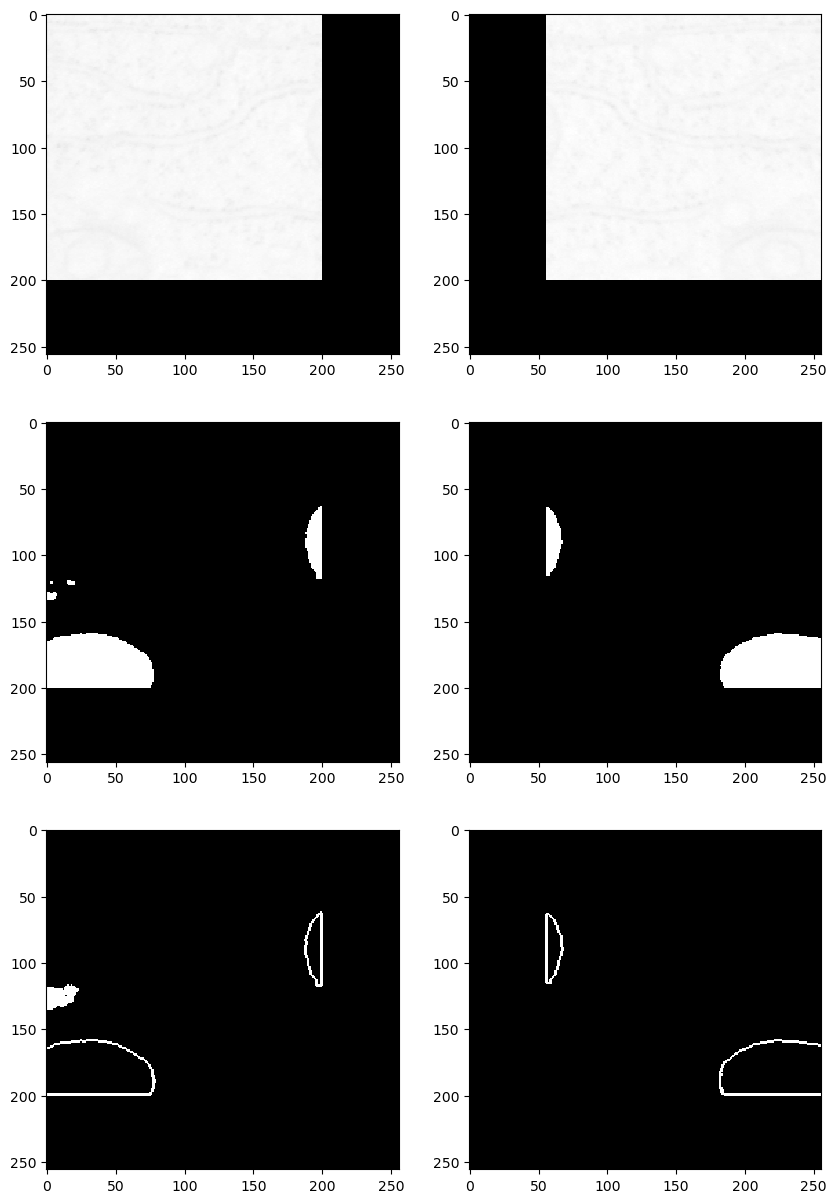

Validation samples


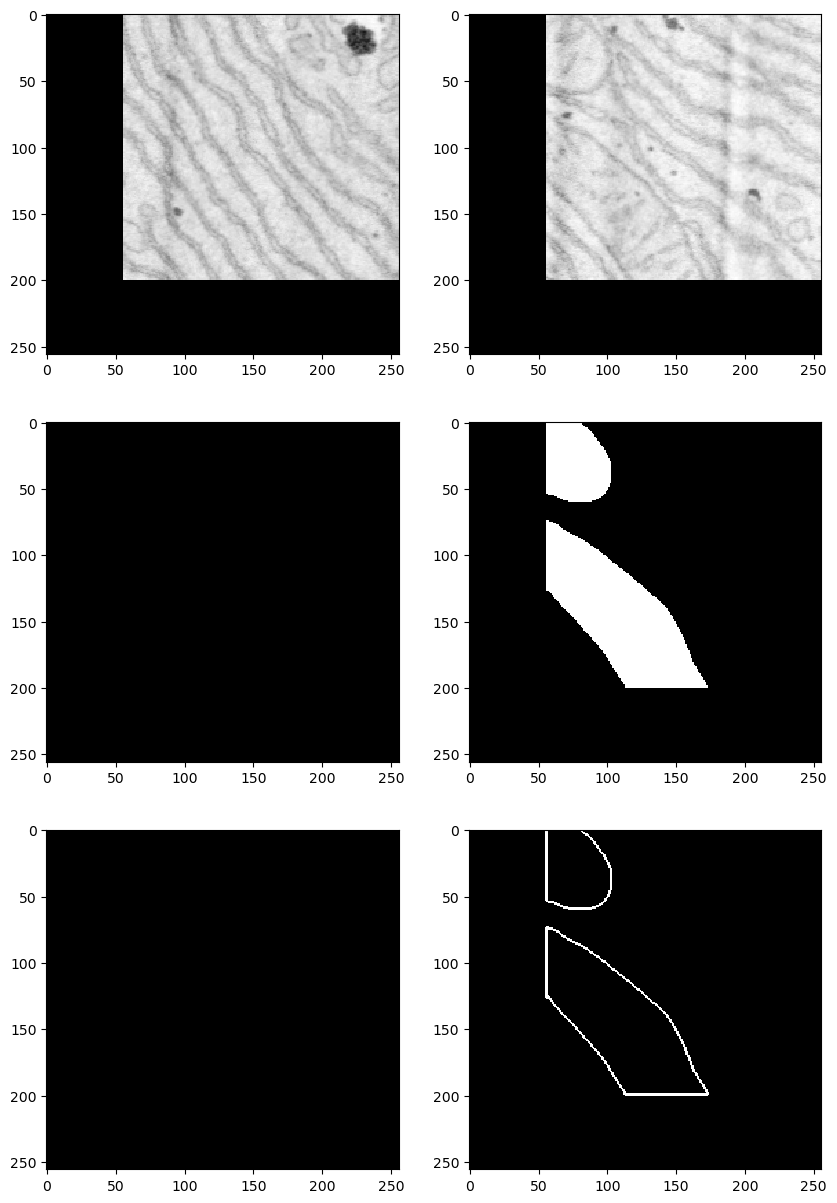

In [25]:
try:
    import napari
except Exception:
    print("use_napari was set to True, but napari is not availabel, using matplotlib as fallback solution")
    use_napari = False

print("Training samples")
check_loader(train_loader, n_samples, plt=not use_napari)
print("Validation samples")
check_loader(val_loader, n_samples, plt=not use_napari)

## Network architecture

Choose the important network architecture parameters for the 2d UNet:
- `scale_factors`: the down/upscaling factors between each encoder/decoder level. This is specified as a list of 3d scale factors, which enables anisotropic scaling. See the example in the comments for details.
- `initial_features`: the number of features in the first encoder level, the number will be doubled for each level
- `final_activation`: the activation applied to the UNet output
- `in_channels`: the number of input channels (= number of channels of the raw data)
- `out_channels`: the number of output channels (usually the number of target channels)

If you're unsure about these settings just use the default values, they are probably ok.

In [17]:
# CONFIGURE ME

# example for isotropic scaling with a depth of 4
# scale_factors = 4 * [[2, 2, 2]]

# example for 4 levels with anisotropic scaling in the first two levels (scale only in xy)
scale_factors = [[1, 2, 2], [1, 2, 2], [2, 2, 2], [2, 2, 2]]

initial_features = 32
final_activation = None

# If you leave the in/out_channels as None an attempt will be made to automatically deduce these numbers. 
in_channels = None
out_channels = None

In [18]:
if final_activation is None and loss == "dice":
    final_activation = "Sigmoid"
    print("Adding a sigmoid activation because we are using dice loss")

if in_channels is None:
    in_channels = 1

if out_channels is None:
    if affinities:
        n_off = len(offsets)
        out_channels = n_off + 1 if foreground else n_off
    elif boundaries:
        out_channels = 2 if foreground else 1
    elif foreground:
        out_channels = 1
    assert out_channels is not None, "The number of out channels could not be deduced automatically. Please set it manually in the cell above."

print("Creating 3d UNet with", in_channels, "input channels and", out_channels, "output channels.")
model = AnisotropicUNet(
    in_channels=in_channels, out_channels=out_channels, scale_factors=scale_factors, final_activation=final_activation
)

Adding a sigmoid activation because we are using dice loss
Creating 3d UNet with 1 input channels and 2 output channels.


## Tensorboard

Start the tensorboard in order to keep track of the training progress.

In [19]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2880642), started 0:26:47 ago. (Use '!kill 2880642' to kill it.)

## Training

Choose additional training parameter:
- `experiment_name`: the name for this training run, which will be used for naming the checkpoint for this model and for identifying the model in tensorboard.
- `n_iterations`: number of iterations to train for.
- `learning_rate`: the learning rate for gradient based updates.

This also starts the training!

**Important:** If you're on google colab the checkpoint will not be saved permanently. To save it you will need to copy the local folder `checkpoints` to your google drive.

In [20]:
# CONFIGURE ME
experiment_name = "my-shiny-net"
n_iterations = 10000
learning_rate = 1.0e-4

In [21]:
# IMPORTANT! if your session on google colab crashes here, you will need to uncomment the 'logger=None' comment
# in this case you can't use tensorboard, but everything else will work as expected
# (this happens due to incompatible google protobuf versions and I don't have time to fix this right now)
trainer = torch_em.default_segmentation_trainer(
    name=experiment_name, model=model,
    train_loader=train_loader, val_loader=val_loader,
    loss=loss_function, metric=metric_function,
    learning_rate=learning_rate,
    mixed_precision=True,
    log_image_interval=50,
    # logger=None
)
trainer.fit(n_iterations)

Compiling pytorch model ...
Start fitting for 10000 iterations /  21 epochs
with 490 iterations per epoch
Training with single precision


Epoch 0:   0%|          | 3/10000 [04:58<272:11:53, 98.02s/it] 

KeyboardInterrupt: 

## Check trained network

Look at predictions from the trained network and their comparison to the target.

In [ ]:
# CONFIGURE ME

# Choose the number of samples to check.
n_samples = 2

# Whether to use napari or matplotlib to view the training data.
# Napari can display 3d volumes, but it might not be installed by default and is not available on google colab.
use_napari = False

In [ ]:
try:
    import napari
except Exception:
    print("use_napari was set to True, but napari is not availabel, using matplotlib as fallback solution")
    use_napari = False

check_trainer(trainer, n_samples, plt=not use_napari)

## Export network to bioimage.io format

Finally, you can export the trained model in the format compatible with [BioImage.IO](https://bioimage.io/#/), a modelzoo for bioimage analysis. After exporting, you can upload the model there to share it with other researchers.
You only need to configure where to save the model via `export_folder` and whether to convert it to additional formats via `additional_weight_formats` and you will be prompted to enter additional information when you run the second cell. You should also write some documentation for the model in `doc`.

In [ ]:
# CONFIGURE ME

# The folder where the bioimageio model will be saved (as a .zip file).
# If you run in google colab you should adapt this path to your google drive so that you can download the saved model.
export_folder = "./my-fancy-bio-model"

# Whether to convert the model weights to additional formats.
# Currently, torchscript and onnx are support it and this will enable running the model
# in more software tools.
additional_weight_formats = None
# additional_weight_formats = ["torchscript"]

doc = None
# write some markdown documentation like this, otherwise a default documentation text will be used
# doc = """#My Fancy Model
# This is a fancy model to segment shiny objects in images.
# """

In [ ]:
import torch_em.util.modelzoo

for_dij = additional_weight_formats is not None and "torchscript" in additional_weight_formats

training_data = None
if preconfigured_dataset is not None:
    if preconfigured_dataset.startswith("platynereis"):
        data_id = torchem_data.get_bioimageio_dataset_id("platynereis")
    else:
        data_id = torchem_data.get_bioimageio_dataset_id(preconfigured_dataset)
    if data_id:
        training_data = {"id": data_id}

pred_str = ""
if affinities:
    pred_str = "affinities and foreground probabilities" if foreground else "affinities"
elif boundaries:
    pred_str = "boundary and foreground probabilities" if foreground else "boundaries"
elif foreground:
    pred_str = "foreground"

default_doc = f"""#{experiment_name}

This model was trained with [the torch_em 3d UNet notebook](https://github.com/constantinpape/torch-em/blob/main/experiments/3D-UNet-Training.ipynb).
"""
if pred_str:
    default_doc += f"It predicts {pred_str}.\n"

training_summary = torch_em.util.get_training_summary(trainer, to_md=True, lr=learning_rate)
default_doc += f"""## Training Schedule

{training_summary}
"""

if doc is None:
    doc = default_doc

torch_em.util.modelzoo.export_bioimageio_model(
    trainer, export_folder, input_optional_parameters=True,
    for_deepimagej=for_dij, training_data=training_data, documentation=doc
)
torch_em.util.modelzoo.add_weight_formats(export_folder, additional_weight_formats)